<a href="https://colab.research.google.com/github/ashwani-adu3839/Speech-To-Speech-Generative-Model/blob/main/Speech_CNN_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pickle import load
import time
import tensorflow as tf
from tensorflow import keras
from google.colab import files
import IPython.display as ipd
from sklearn.model_selection import train_test_split
import collections
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2})
from sklearn.utils import shuffle

In [ ]:
pickle_path_feature = '/feature_mel_all.pkl'
path='/Speech_to_Speech/'

In [ ]:
FRAME_SIZE = 1024
HOP_LENGTH = 200
DURATION = 0.8  # in seconds
SAMPLE_RATE = 22050
MEL_CHANNELS = 60
win_length  =  1011
max_db = 100
ref_db = 20
power = 0.5

In [ ]:
def load_features(filename):
    # load all features
    data = load(open(filename, 'rb'))

    datax = data["feauture_mfcc"]
    words = data["mapping"]
    labels = []
    for word in words:
      if  word == 'zero':
        label = 0
      if word == 'one':
        label = 1       
      if word == 'two':
        label = 2
      if word == 'three':
        label = 3        
      if word == 'four':
        label = 4
      if word == 'five':
        label = 5        
      if word == 'six':
        label = 6       
      if word == 'seven':
        label = 7  
      if word == 'eight':
        label = 8  
      if word == 'nine':
        label = 9  
      labels.append(label)
    
    x_data = []
    for mel in datax:
        norm_mel = mel
        x_data.append(norm_mel)
        
    length = [x.shape[0] for x in x_data]
    
    pad_len = max([x.shape[0] for x in x_data])
    if pad_len%2 != 0:
       pad_len = pad_len+1
    pad_len = 88   
    pad_mel = 56
    pad_arr = [np.pad(x, ((0, pad_len), (0, 0)), 'constant', constant_values=(0))[:pad_len, :pad_mel] for x in x_data]

    
    return pad_arr,labels, length
x_data,y_word, length = load_features(pickle_path_feature)

In [ ]:
x = np.array(x_data)
xy=np.reshape(x[2], (x[2].shape[0],x[2].shape[1]))
plt.imshow(xy.T)
#plt.colorbar()

In [ ]:
_, T_shape, mel_channels = x.shape
T_shape, mel_channels

(88, 56)

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(np.asarray(x), np.array(y_word) , test_size=10, random_state=42)
x_train.shape, x_valid.shape, y_train.shape

((2990, 88, 56), (10, 88, 56), (2990,))

In [ ]:
x_train = np.expand_dims(x_train, -1).astype("float32")
x_valid = np.expand_dims(x_valid, -1).astype("float32")

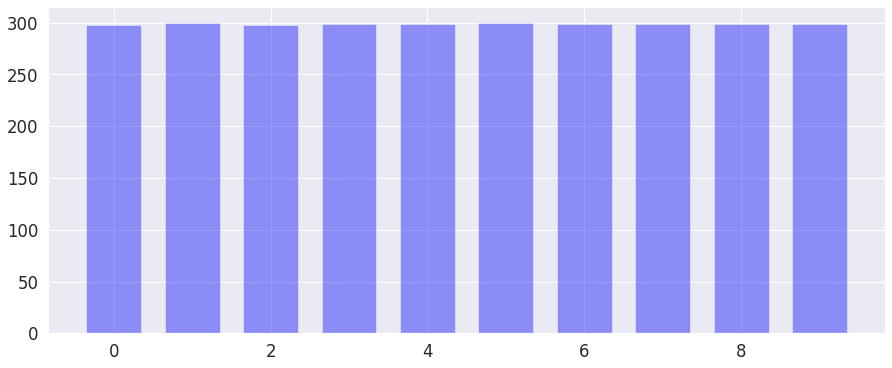

In [ ]:
y_trainx =np.reshape(y_train, (y_train.shape[0]))
np.unique(y_trainx)
elements_count = collections.Counter(y_trainx.tolist())
plt.figure(figsize =(15, 6))
plt.bar(elements_count.keys(),elements_count.values(), color = 'b', width = 0.7, alpha =0.4)
plt.show()

In [ ]:
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)


BUFFER_SIZE_TEST = x_valid.shape[0]
dataset_test = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).shuffle(BUFFER_SIZE_TEST)
dataset_test = dataset_test.batch(1)

In [ ]:
cnn_filters=(512, 256, 128, 64)
cnn_kernels=(3, 3, 3, 3)
cnn_strides=(2, 2, 2, 1)
latent_dim=32
omega = 0.1 # KL loss contribution  

In [ ]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
class Conv_Layer(tf.keras.layers.Layer):
  def __init__(self, filter, kernel, stride):
    super(Conv_Layer, self).__init__()
    self.filter = filter 
    self.kernel = kernel 
    self.stride = stride 
    self.cnn_layer = tf.keras.layers.Conv2D(
            filters=self.filter, kernel_size=self.kernel, strides=self.stride, padding="same", activation='relu')
    self.BatchNorm = tf.keras.layers.BatchNormalization()
  def call(self, x):
    x = self.cnn_layer(x) 
    x = self.BatchNorm(x)
    return x

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, cnn_filters, cnn_kernels, cnn_strides, latent_dim):
    super(Encoder, self).__init__()
    self.cnn_filters = cnn_filters 
    self.cnn_kernels = cnn_kernels 
    self.cnn_strides = cnn_strides 
    self.latent_dim = latent_dim 
    self.num_cnn_layers = len(cnn_filters)

    self.enc_layers = [Conv_Layer(self.cnn_filters[i], self.cnn_kernels[i], self.cnn_strides[i])    for i in range(self.num_cnn_layers)]
    self.flattern = tf.keras.layers.Flatten()
    self.Flat_layer = tf.keras.layers.Dense(cnn_filters[-1])

    self.dense_mean = tf.keras.layers.Dense(latent_dim)
    self.dense_log_var = tf.keras.layers.Dense(latent_dim)
    self.sampling = Sampling()

  def call(self, x, training):

    for i in range(self.num_cnn_layers):
      x = self.enc_layers[i](x)
    shape_before_bottleneck = x.shape[1:]

    x = self.flattern(x) 
    x = self.Flat_layer(x)
    z_mean = self.dense_mean(x)
    z_log_var = self.dense_log_var(x)
    z = self.sampling((z_mean, z_log_var))
    
    return z_mean, z_log_var, z,shape_before_bottleneck  # (batch_size, latent_dim)

In [ ]:
encode = Encoder(cnn_filters, cnn_kernels, cnn_strides, latent_dim)

In [ ]:
for inp, tar in dataset_test:
    print(inp.shape)
    break
a,b,c, d_shape=encode(inp)
a.shape,b.shape,c.shape, d_shape

(1, 88, 56, 1)


(TensorShape([1, 32]),
 TensorShape([1, 32]),
 TensorShape([1, 32]),
 TensorShape([11, 7, 64]))

In [ ]:
class ConvTrans_Layer(tf.keras.layers.Layer):
  def __init__(self, filter, kernel, stride):
    super(ConvTrans_Layer, self).__init__()
    self.filter = filter 
    self.kernel = kernel 
    self.stride = stride 
    self.cnn_layer = tf.keras.layers.Conv2DTranspose(
            filters=self.filter, kernel_size=self.kernel, strides=self.stride, padding="same", activation='relu')
    self.BatchNorm = tf.keras.layers.BatchNormalization()
  def call(self, x):
    x = self.cnn_layer(x) 
    x = self.BatchNorm(x)
    return x

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, cnn_filters, cnn_kernels, cnn_strides, d_shape):
    super(Decoder, self).__init__()
    self.d_shape = d_shape
    self.num_neurons = np.prod(self.d_shape) 
    self.dense_layer = tf.keras.layers.Dense(self.num_neurons, name="decoder_dense")
    self.reshape = tf.keras.layers.Reshape(self.d_shape)

    self.cnn_filters = cnn_filters
    self.cnn_kernels = cnn_kernels 
    self.cnn_strides = cnn_strides
    self.latent_dim = latent_dim 
    self.num_cnn_layers = len(cnn_filters)

    self.dec_layers = [ConvTrans_Layer(self.cnn_filters[i], self.cnn_kernels[i], self.cnn_strides[i])    for i in reversed(range(self.num_cnn_layers))]
    self.dec_last = tf.keras.layers.Conv2DTranspose(
            filters=1,
            kernel_size=3, #self.cnn_kernels[0],
            strides=1,
            padding="same")

   
  def call(self, x):
     x = self.dense_layer(x)
     x = self.reshape(x)
     for i in range(self.num_cnn_layers):
          x = self.dec_layers[i](x)
     reconstruct = self.dec_last(x)
    
     return reconstruct


In [ ]:
decode = Decoder(cnn_filters, cnn_kernels, cnn_strides, d_shape)

In [ ]:
decode(c).shape

TensorShape([1, 88, 56, 1])

In [ ]:
class VAE(tf.keras.Model):
  def __init__(self,cnn_filters, cnn_kernels, cnn_strides, d_shape, latent_dim):
    super(VAE, self).__init__()


    self.encoder = Encoder(cnn_filters, cnn_kernels, cnn_strides, latent_dim)

    self.decoder = Decoder(cnn_filters, cnn_kernels, cnn_strides, d_shape) 


  def call(self, inp, training):

    z_mean, z_log_var, z,_ = self.encoder(inp)  

    reconstructed = self.decoder(z)

 
    kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
    self.add_loss(kl_loss)
    return reconstructed, z_mean, z_log_var, z

In [ ]:
vae = VAE(cnn_filters, cnn_kernels, cnn_strides, d_shape, latent_dim)

In [ ]:
for (batch, (inp, _)) in enumerate(dataset):
      break
a,b,c,d = vae(inp)
a.shape, b.shape, c.shape, d.shape, inp.shape

(TensorShape([64, 88, 56, 1]),
 TensorShape([64, 32]),
 TensorShape([64, 32]),
 TensorShape([64, 32]),
 TensorShape([64, 88, 56, 1]))

In [ ]:
mse_loss_fn = tf.keras.losses.MeanSquaredError()
binar_loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

In [ ]:
checkpoint_path = path+"/trainCNN32"

ckpt = tf.train.Checkpoint(vae=vae,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

In [ ]:
@tf.function
def train_step(inp):
  with tf.GradientTape() as tape:
    reconstructed, z_mean, z_log_var, z = vae(inp)
    reconstruction_loss = tf.reduce_mean(
                 tf.reduce_sum(tf.keras.losses.mean_squared_error(inp, reconstructed), axis=(1, 2)))
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    kl_loss = omega*tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    total_loss = reconstruction_loss + kl_loss
    
  gradients = tape.gradient(total_loss, vae.trainable_variables)
  optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
  return total_loss, kl_loss, reconstruction_loss

In [ ]:
EPOCHS = 100
history = {
  "epoch": [],
  "loss": []  
}
for epoch in range(EPOCHS):
  start = time.time()
  total_loss = 0
  epoch_loss_KL = 0
  epoch_loss_recon = 0
  epoch_loss = 0
#  train_loss.reset_states()
  for (batch, (inp, _)) in enumerate(dataset):
    loss, KLD, bce_loss = train_step(inp)
    epoch_loss_recon += bce_loss
    epoch_loss_KL += KLD
    epoch_loss += loss 
  epoch_loss_recon = epoch_loss_recon/(batch+1)
  epoch_loss_KL = epoch_loss_KL/(batch+1)
  epoch_loss = epoch_loss/(batch+1)
  history['epoch'].append(epoch)
  history['loss'].append(epoch_loss)
  if (epoch+1) % 100 == 0: 
     ckpt_save_path = ckpt_manager.save()
  if (epoch+1) % 1 == 0:    
    print(f'Epoch {epoch + 1} Loss {epoch_loss:.4f}, VAE Loss {epoch_loss_KL:.4f}, Reconstruction Loss {epoch_loss_recon:.4f}')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Loss 7.7993, VAE Loss 3.0418, Reconstruction Loss 4.7575
Time taken for 1 epoch: 12.82 secs

Epoch 2 Loss 7.7132, VAE Loss 3.0069, Reconstruction Loss 4.7063
Time taken for 1 epoch: 8.92 secs

Epoch 3 Loss 7.7290, VAE Loss 3.0208, Reconstruction Loss 4.7082
Time taken for 1 epoch: 8.90 secs

Epoch 4 Loss 7.7199, VAE Loss 3.0424, Reconstruction Loss 4.6775
Time taken for 1 epoch: 8.90 secs

Epoch 5 Loss 7.7471, VAE Loss 3.0305, Reconstruction Loss 4.7166
Time taken for 1 epoch: 8.90 secs

Epoch 6 Loss 7.7301, VAE Loss 3.0231, Reconstruction Loss 4.7071
Time taken for 1 epoch: 8.90 secs

Epoch 7 Loss 7.7025, VAE Loss 3.0088, Reconstruction Loss 4.6937
Time taken for 1 epoch: 8.90 secs

Epoch 8 Loss 7.7293, VAE Loss 3.0194, Reconstruction Loss 4.7099
Time taken for 1 epoch: 8.91 secs

Epoch 9 Loss 7.7358, VAE Loss 3.0139, Reconstruction Loss 4.7219
Time taken for 1 epoch: 8.90 secs

Epoch 10 Loss 7.7444, VAE Loss 3.0428, Reconstruction Loss 4.7016
Time taken for 1 epoch: 8.91 secs

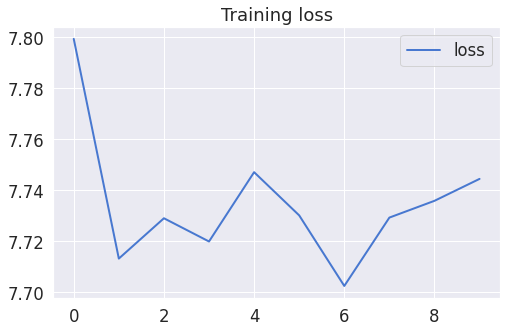

In [ ]:
plt.figure(figsize=(8,5))# Loss 7.7444, VAE Loss 3.0428, Reconstruction Loss 4.7016 Latent = 32
#plt.yscale("log")      
plt.plot(history["epoch"],history["loss"], label='loss')
plt.title('Training loss')
plt.legend(loc='best')
plt.show()

In [ ]:
def evaluate(inp):
  reconstructed, _, _,_ = vae(inp)
 
  return reconstructed

In [ ]:
import copy
import librosa
def griffin_lim(spectrogram, rate=1):
#    spectrogram=spectrogram/10.0
    mel = np.transpose(spectrogram[1:-1,:])

        # de-noramlize
    mel = (np.clip(mel, 0, 1) * max_db) - max_db + ref_db

      # to amplitude
    spectrogram = np.power(10.0, mel * 0.05)
    S = librosa.feature.inverse.mel_to_stft(
            spectrogram,
            power=0.5,
            sr=SAMPLE_RATE,
            n_fft=FRAME_SIZE,
            fmin=0,
            fmax=None)
    S_slow = librosa.core.phase_vocoder(S, rate=rate, hop_length=HOP_LENGTH)

    y = librosa.griffinlim(
            S_slow,
            n_iter=32,
            hop_length=HOP_LENGTH,
            win_length=win_length)

    return y

In [ ]:
number = 8

for (batch, (inp,tar)) in enumerate(dataset_test):
    out = evaluate(inp)
   
    img_inp = inp[0,:,:,0].numpy()
    img_out = out[0,:,:,0].numpy()
    y = griffin_lim(img_inp, rate=1)
    print("\n\nDigit : ", tar[0].numpy())
    ipd.display(ipd.Audio(y, rate=SAMPLE_RATE))
    print(" Original  sound ")

    y = griffin_lim(img_out, rate=1)
    ipd.display(ipd.Audio(y, rate=SAMPLE_RATE))
    print(" Reconstructed  Sound ")
    if batch>=(number-1):
        break



Digit :  4


 Original  sound 


 Reconstructed  Sound 


Digit :  9


 Original  sound 


 Reconstructed  Sound 


Digit :  2


 Original  sound 


 Reconstructed  Sound 


Digit :  0


 Original  sound 


 Reconstructed  Sound 


Digit :  7


 Original  sound 


 Reconstructed  Sound 


Digit :  6


 Original  sound 


 Reconstructed  Sound 


Digit :  0


 Original  sound 


 Reconstructed  Sound 


Digit :  3


 Original  sound 


 Reconstructed  Sound 


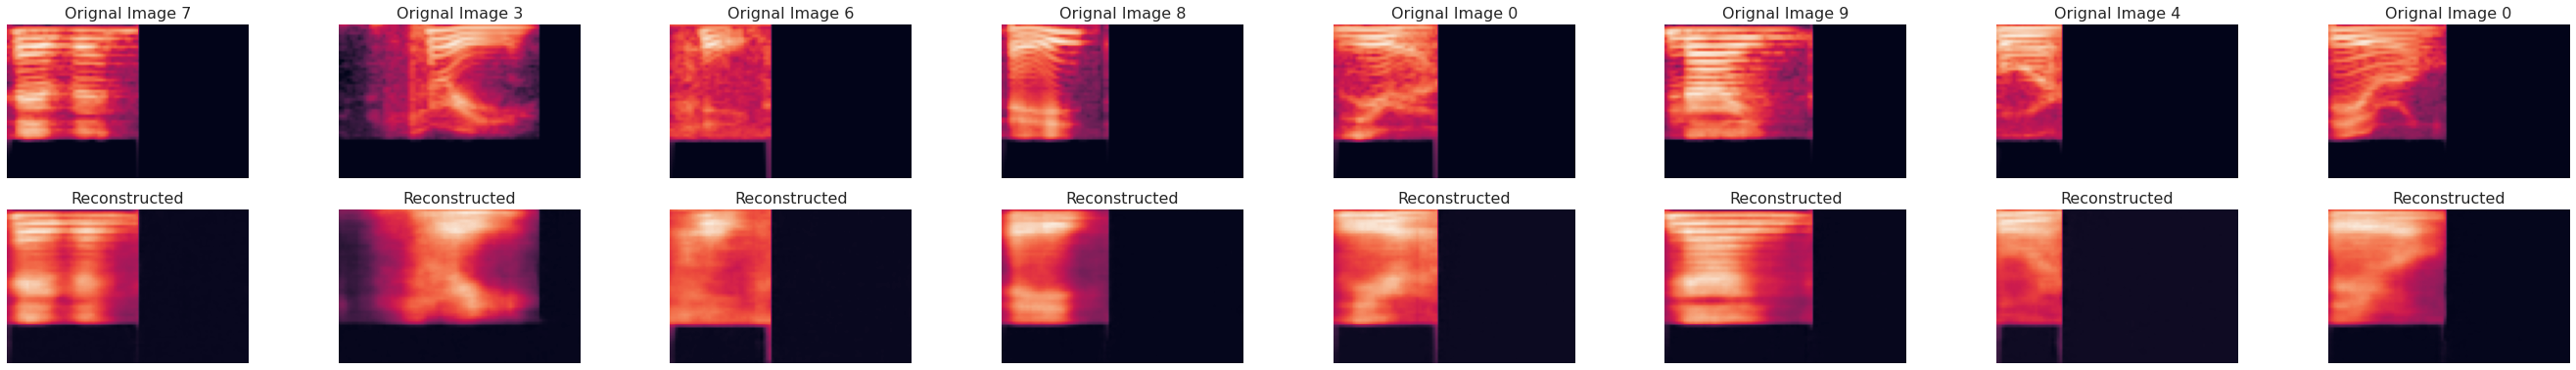

In [ ]:
plt.figure(figsize=(6*number, 6*number))
grid = plt.GridSpec(2, number, wspace=0.1,  bottom=0.3, top=0.4)

for (batch, (inp,tar)) in enumerate(dataset_test):
    out = evaluate(inp)
   
    img_inp = inp[0,:,:,0].numpy()
    img_out = out[0,:,:,0].numpy()


    plt.subplot(grid[0, batch])
    plt.imshow(img_inp.T)
    plt.title(f'Orignal Image {(tar[0])}', fontsize=16)
    plt.axis("off")

    plt.subplot(grid[1, batch])
    plt.imshow(img_out.T)

    plt.title(f'Reconstructed', fontsize=16)
    plt.axis("off")  

    if batch>=(number-1):
        break


In [ ]:
z_mean_total = []
tar_total = []
for i,(inp,tar) in enumerate(dataset):
  re, z_mean, _, _ = vae(inp)
  for z,t in zip(z_mean,tar):
      z_mean_total.append(z)
      tar_total.append(t)
  # if i>40:
  #   break
z_mean_total = np.array(z_mean_total)
tar_total = np.array(tar_total)

In [ ]:
z_mean_total.max(), z_mean_total.min()

(5.042362, -4.40332)

In [ ]:
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    plt.figure(figsize=(12, 10))
    plt.scatter(x[:, 0], x[:, 1], c=colors,cmap=plt.cm.get_cmap('magma', 10))
    plt.colorbar(ticks=range(10), label='digit value')
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 2990 samples in 0.011s...
[t-SNE] Computed neighbors for 2990 samples in 0.596s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2990
[t-SNE] Computed conditional probabilities for sample 2000 / 2990
[t-SNE] Computed conditional probabilities for sample 2990 / 2990
[t-SNE] Mean sigma: 0.912392
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.267990
[t-SNE] KL divergence after 2000 iterations: 0.744703
t-SNE done! Time elapsed: 25.782289743423462 seconds


<Figure size 576x576 with 0 Axes>

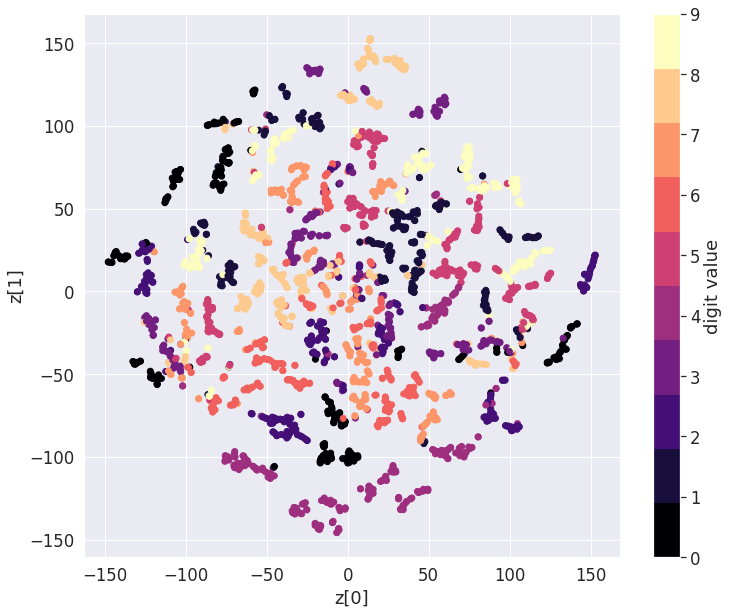

In [ ]:
from sklearn.manifold import TSNE
time_start = time.time()
RS = 123

fashion_tsne = TSNE(n_components=2, verbose=1,learning_rate =200, n_iter=2000, perplexity=5).fit_transform(z_mean_total)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
fashion_scatter(fashion_tsne, tar_total)

In [ ]:
# def plot_label_clusters(z_mean_total, tar_total):
#   plt.figure(figsize=(12, 10))
#   plt.scatter(z_mean_total[:, 0], z_mean_total[:, 1], c=tar_total)
#   plt.scatter(z_mean_total[:, 0], z_mean_total[:, 16], c=tar_total)
#   plt.scatter(z_mean_total[:, 0], z_mean_total[:, 30], c=tar_total)

#   plt.colorbar()
#   plt.xlabel("z[0]")
#   plt.ylabel("z[1]")

# plt.show()
 
# plot_label_clusters(z_mean_total, tar_total)

In [ ]:
# Almost all points are less than |2|

In [ ]:
#  Generate sound from latent space
def generate(vae, z_sample):
    x_decoded = vae.decoder(z_sample)
    img_out = x_decoded[0,:,:,0].numpy()
    y = griffin_lim(img_out, rate=1)
    print("\n\n\n Reconstructed  Sound ")
    plt.imshow(img_out.T)
    plt.axis("off")
    plt.show()
    ipd.display(ipd.Audio(y, rate=SAMPLE_RATE))




 Reconstructed  Sound 


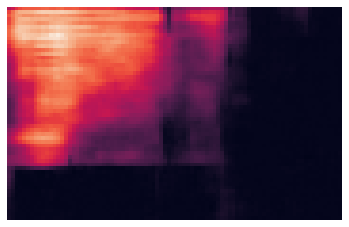




 Reconstructed  Sound 


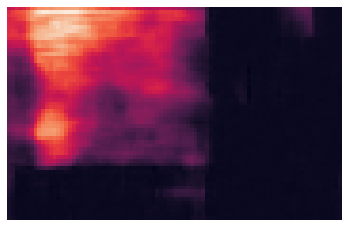




 Reconstructed  Sound 


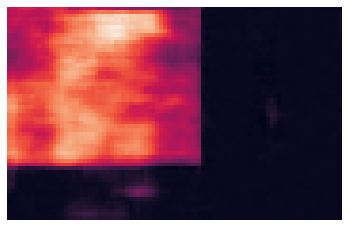




 Reconstructed  Sound 


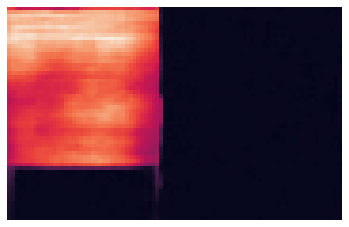




 Reconstructed  Sound 


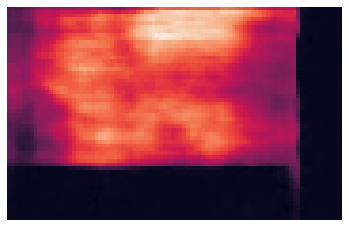




 Reconstructed  Sound 


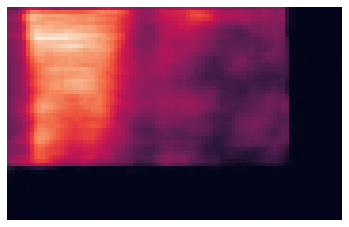




 Reconstructed  Sound 


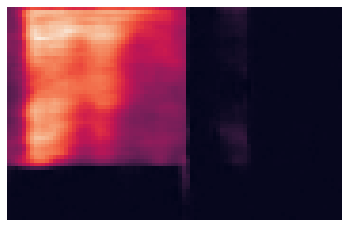




 Reconstructed  Sound 


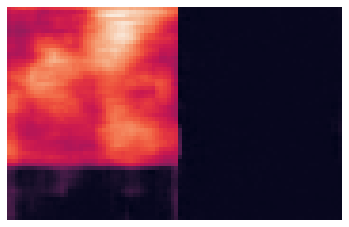

In [ ]:
Num = 8
for i in range(Num):
    z_sample = tf.random.normal([1,32], mean=0.0, stddev=1.5) # generate latent space sample points for decoder
    generate(vae, z_sample)